In [1]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

PATH = "/mnt/d/Datasets/"
imgPATH = PATH + "mini-DDSM/MINI-DDSM-Complete-PNG-16/"
ddsm_roi_path = PATH + "mini-DDSM/ROI_2/"
vindr_roi_path = PATH+"/Vindr-Mammo/ROI/"
data_path = PATH + "mini-DDSM/fullimg/"
save_dir = "/home/jj/FYP/Models/"
combined_path = PATH + "combined/"
image_size = 300
batch_size = 16
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

2023-02-06 02:20:43.926524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 02:20:43.959877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 02:20:43.959916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# load ddsm

In [42]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  ddsm_roi_path,
#   label_mode="categorical",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=None)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  ddsm_roi_path,
#   label_mode="categorical",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=None)

Found 2830 files belonging to 2 classes.
Using 2264 files for training.
Found 2830 files belonging to 2 classes.
Using 566 files for validation.


# load vindr

In [4]:
# train_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)
# val_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)

# combined

In [5]:
# train_combined = tf.keras.utils.image_dataset_from_directory(
#   combined_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=1)
# val_combined = tf.keras.utils.image_dataset_from_directory(
#   combined_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=1)

In [6]:
preprocessing = preprocess_input
pre_trained = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.5),fill_mode="reflect"),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode="reflect"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode="reflect")
  ])
#Define model architect
tfinput = Input(shape=(image_size,image_size,3))
# data_augment = data_augmentation(tfinput)
pre_process = preprocessing(tfinput)
efficientnetv2m_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(efficientnetv2m_model)
# DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(1024,activation = 'relu')(flatten)
x=Dropout(0.7)(Dense1)
x = Dense(512,activation='relu')(x)
DO2 = Dropout(0.7)(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800

In [43]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False,batch_size=32):
  # # Resize and rescale all datasets.
  
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.3),fill_mode="nearest"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="nearest"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="nearest")
  ])
  if shuffle:
    ds = ds.shuffle(1000)

  
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
    #           num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (data_augmentation(x,training=True),y), 
                num_parallel_calls=AUTOTUNE)
  # Batch all datasets.
  
  # print(ds)
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [44]:
train_ds_aug = prepare(train_ds,shuffle=False,augment=True,batch_size=batch_size)
val_ds_aug = prepare(val_ds,batch_size=batch_size)
# train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds_aug= val_ds.prefetch(buffer_size=AUTOTUNE)

In [60]:
# for i in train_ds_aug.take(9):
#  plt.imshow(i[0])
train_ds_aug.take(9)
    

<TakeDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

# initialising

In [9]:
# init_lr = 1e-3
# steps = 1e3
# final_lr = 1e-4
# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
#                                                             ,steps
#                                                             ,final_lr
#                                                             ,power=0.5)

In [10]:
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm_ROI_2/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

Epoch 1/10


2023-02-04 01:39:43.826284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-02-04 01:39:47.607446: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-04 01:39:47.607505: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-04 01:39:47.620387: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

142/142 [==============================] - ETA: 0s - loss: 0.8315 - binary_accuracy: 0.5380 - false_positives: 512.0000 - false_negatives: 534.0000

2023-02-04 01:40:24.027924: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-04 01:40:24.027981: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-04 01:40:24.037783: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-04 01:40:24.037821: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc


Epoch 1: val_binary_accuracy improved from -inf to 0.56360, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm_ROI_2/dense_init_checkpoint/cp-0001.ckpt
142/142 [==============================] - 66s 354ms/step - loss: 0.8315 - binary_accuracy: 0.5380 - false_positives: 512.0000 - false_negatives: 534.0000 - val_loss: 0.6778 - val_binary_accuracy: 0.5636 - val_false_positives: 236.0000 - val_false_negatives: 11.0000
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.7600 - binary_accuracy: 0.5508 - false_positives: 523.0000 - false_negatives: 494.0000
Epoch 2: val_binary_accuracy did not improve from 0.56360
142/142 [==============================] - 26s 165ms/step - loss: 0.7600 - binary_accuracy: 0.5508 - false_positives: 523.0000 - false_negatives: 494.0000 - val_loss: 0.6869 - val_binary_accuracy: 0.5548 - val_false_positives: 236.0000 - val_false_negatives: 16.0000
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.7268 - binary_acc

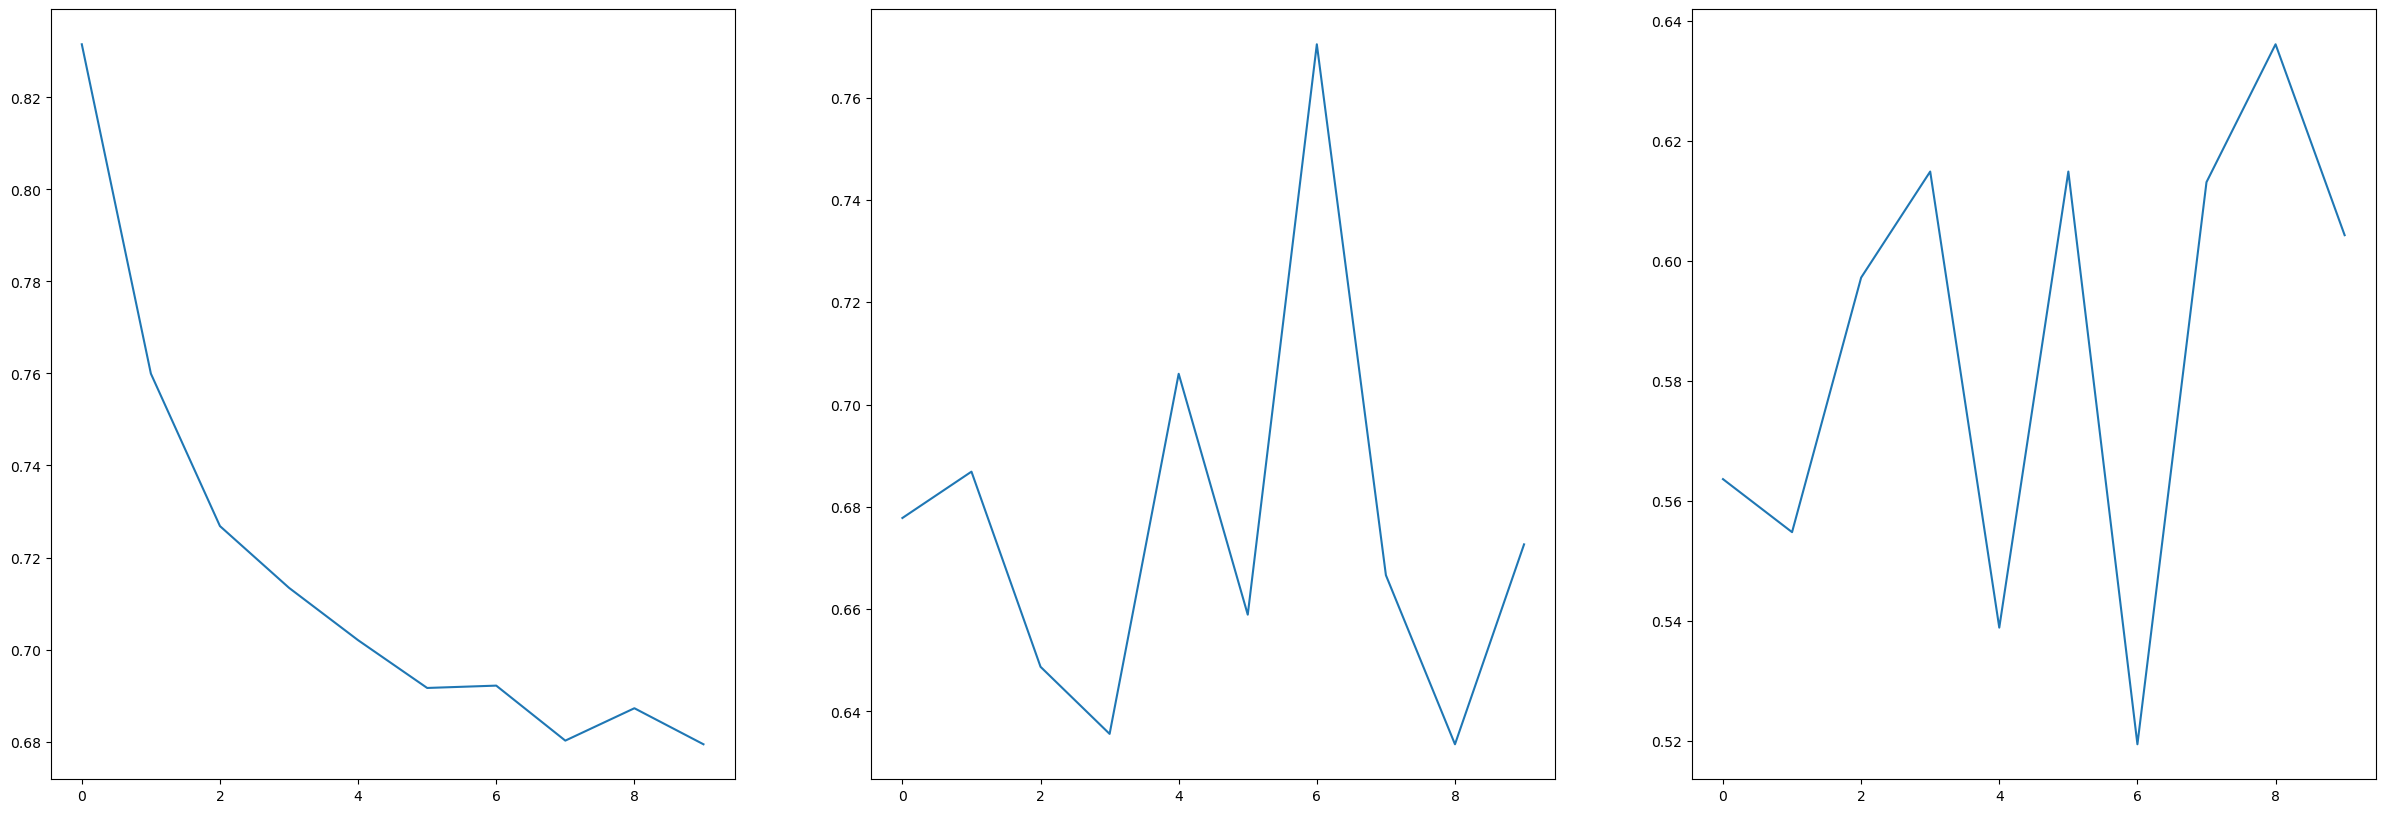

In [11]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 10
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_binary_accuracy'])

# fine tuning

In [12]:
#load model with best performance
# model.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm_ROI_2/dense_init_checkpoint')
model.load_weights(latest)

pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-75]:
  layer.trainable = False
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm_ROI_2/fine_tuning_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm_ROI_2/fine_tuning_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

KeyboardInterrupt: 

In [12]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2')
model.load_weights(latest)
init_lr = 5e-6
steps = 100
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_3/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 50
history_ft_2 = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

Epoch 1/50
142/142 [==============================] - ETA: 0s - loss: 0.5728 - binary_accuracy: 0.6899
Epoch 1: val_loss improved from inf to 0.55857, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_3/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.71378, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_3/cp-0001.ckpt
142/142 [==============================] - 39s 215ms/step - loss: 0.5728 - binary_accuracy: 0.6899 - val_loss: 0.5586 - val_binary_accuracy: 0.7138
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.5728 - binary_accuracy: 0.7036
Epoch 2: val_loss improved from 0.55857 to 0.55692, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_3/cp-0002.ckpt

Epoch 2: val_binary_accuracy did not improve from 0.71378
142/142 [==============================] - 28s 192ms/step - loss: 0.5728 - binary_accuracy: 0.7036 - val_loss: 0.5569 - val_

KeyboardInterrupt: 

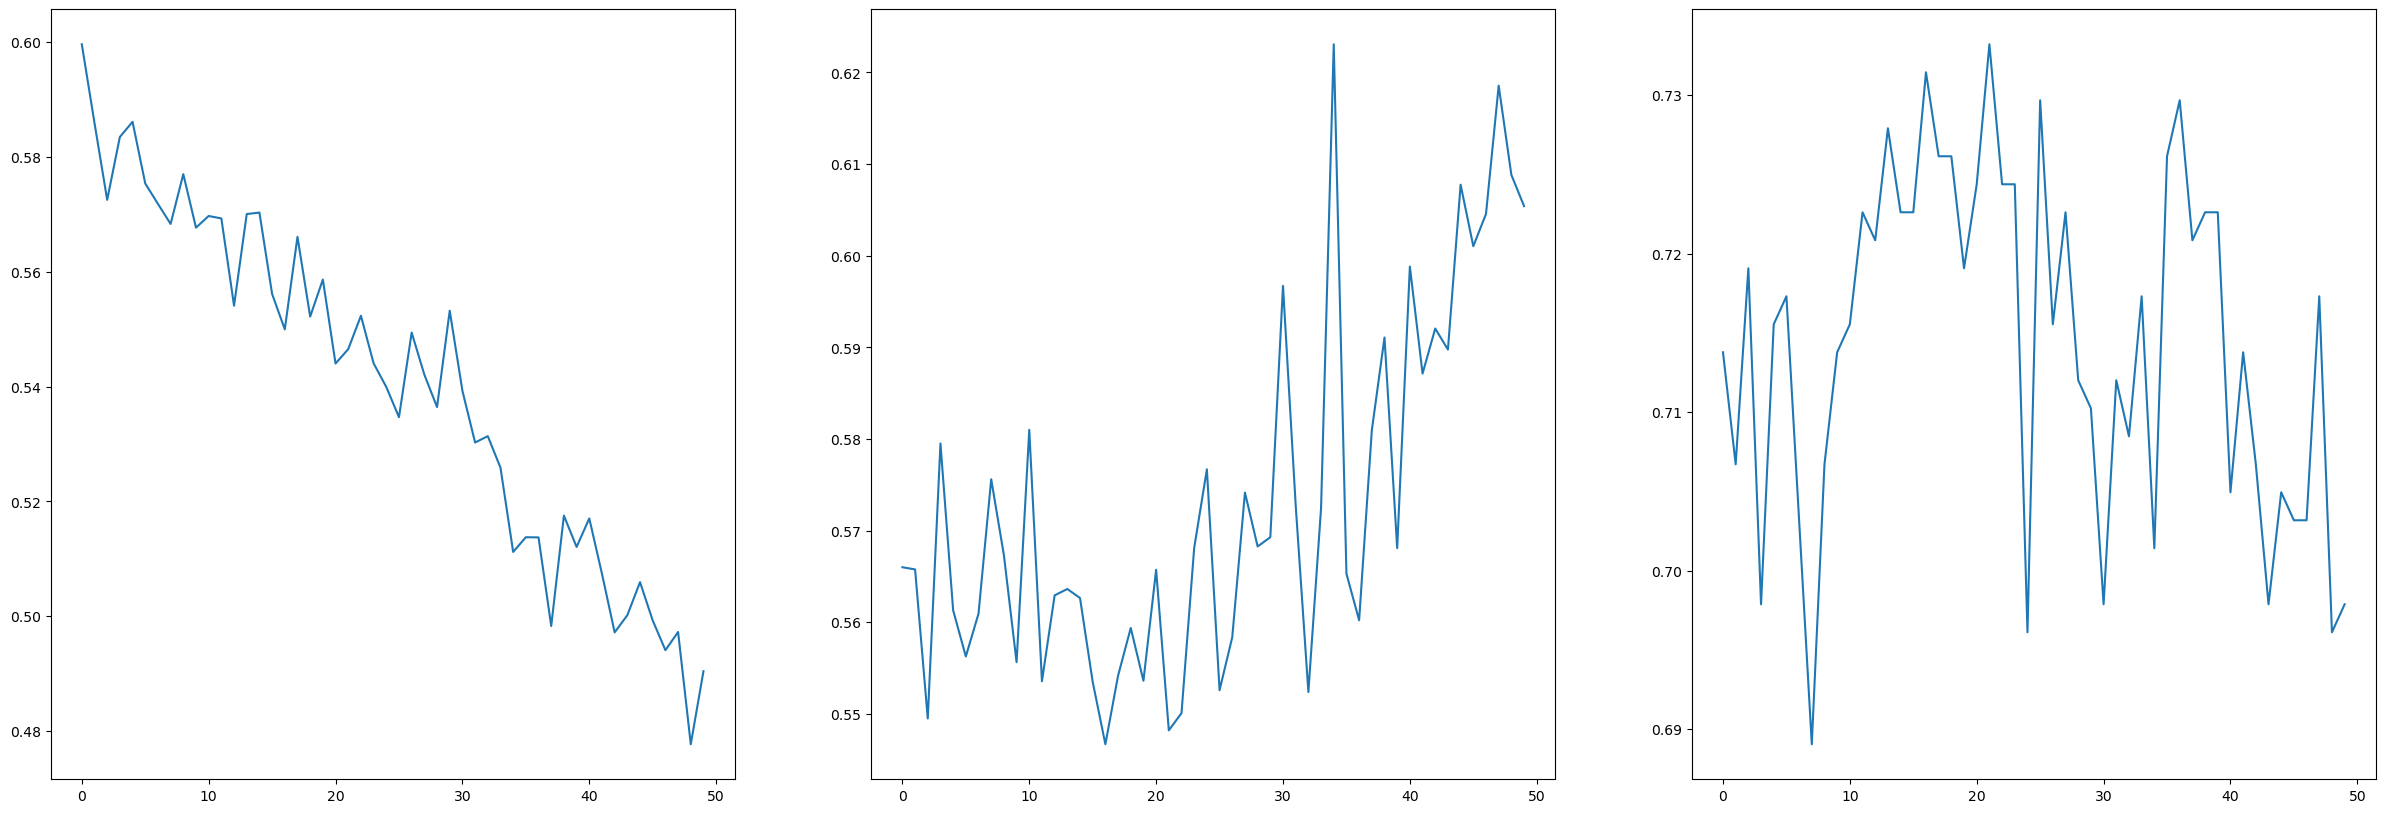

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_ft_2.history['loss'])
plt.subplot(132)
plt.plot(history_ft_2.history['val_loss'])
plt.subplot(133)
plt.plot(history_ft_2.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

2023-02-02 07:44:44.861360: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.861406: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.967682: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


142/142 [==============================] - ETA: 0s - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000
Epoch 1: val_loss improved from inf to 0.56650, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.72261, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-0001.ckpt
142/142 [==============================] - 79s 494ms/step - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000 - val_loss: 0.5665 - val_binary_accuracy: 0.7226 - val_false_positives_1: 72.0000 - val_false_negatives_1: 85.0000
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.5779 - binary_accuracy: 0.6921 - false_positives_1: 215.0000 - false_negatives_1: 482.0000
Epoch 2: val_loss improved from 0.56650 to 0.55574, saving model to /home/jj/FYP/Checkpoint/EfficientNet_d

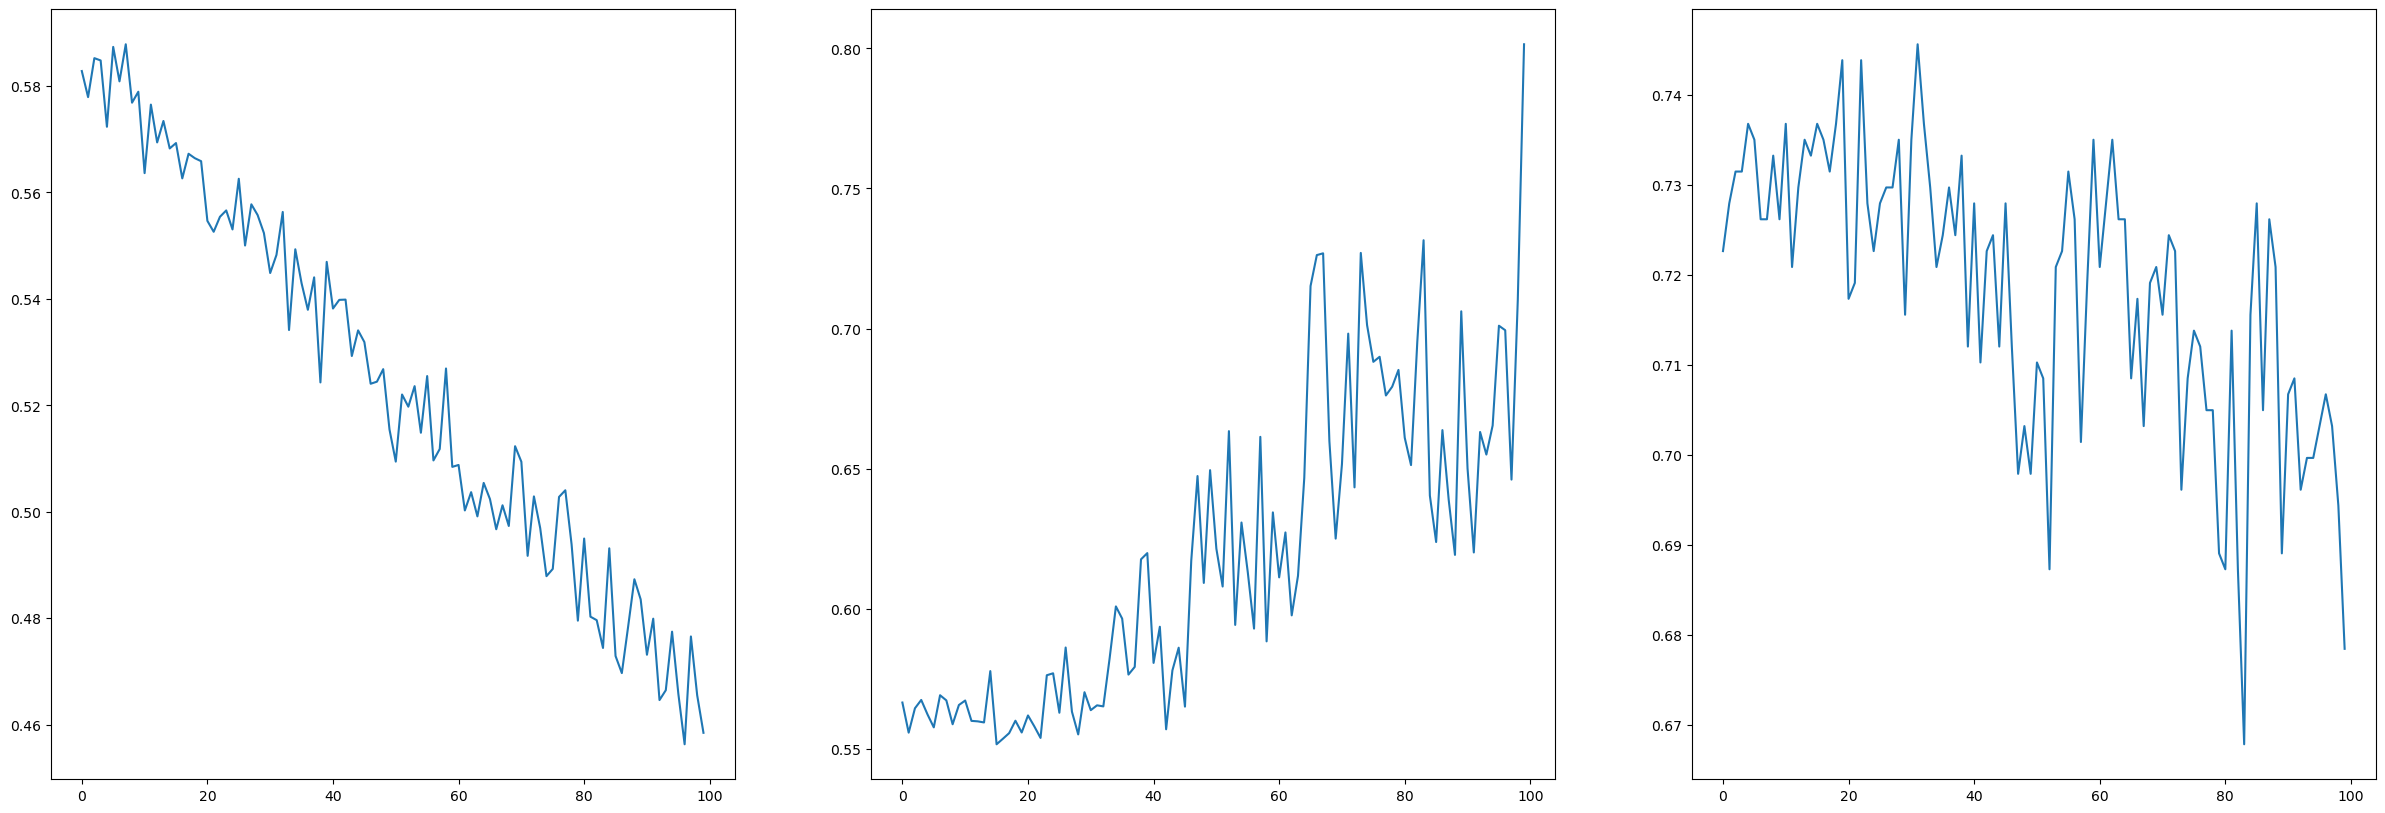

In [10]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss')
model.load_weights(latest)
init_lr = 5e-6
steps = 1e5
final_lr = 1e-7
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-150]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])